In [1]:
!pip install -q gdown 

import gdown
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Все необходимые библиотеки импортированы.")

Все необходимые библиотеки импортированы.


In [2]:
KAGGLE_DATASET_PATH = '../input/train-2/' 
CSV_FILE_PATH = os.path.join(KAGGLE_DATASET_PATH, 'train.csv')

# Путь для скачивания и распаковки аудиоархива
DOWNLOADED_ZIP_PATH = '/kaggle/working/audio_train.zip'
AUDIO_EXTRACT_PATH = '/kaggle/working/audio_train_extracted/' 

# Пути для сохранения промежуточных и итоговых результатов
FEATURES_PKL_PATH = '/kaggle/working/extracted_features.pkl'
MODEL_PKL_PATH = '/kaggle/working/trained_model.pkl'
LABEL_ENCODER_CLASSES_PATH = '/kaggle/working/label_encoder_classes.npy'

In [3]:

google_drive_file_id = '1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ' 

if not os.path.exists(DOWNLOADED_ZIP_PATH):
    print(f"Начало скачивания audio_train.zip с Google Drive...")
    gdown.download(id=google_drive_file_id, output=DOWNLOADED_ZIP_PATH, quiet=False)
    if os.path.exists(DOWNLOADED_ZIP_PATH):
        print(f"Файл audio_train.zip успешно скачан в {DOWNLOADED_ZIP_PATH}")
        print(f"Размер файла: {os.path.getsize(DOWNLOADED_ZIP_PATH) / (1024*1024):.2f} MB")
    else:
        print(f"Ошибка: Файл audio_train.zip не был скачан.")
        # Если скачивание не удалось, дальнейшее выполнение может быть невозможным
        # Можно добавить exit() или raise Exception()
else:
    print(f"Файл {DOWNLOADED_ZIP_PATH} уже существует. Пропускаем скачивание.")
    print(f"Размер существующего файла: {os.path.getsize(DOWNLOADED_ZIP_PATH) / (1024*1024):.2f} MB")

# Распаковка аудиоархива
if os.path.exists(DOWNLOADED_ZIP_PATH):
    if not os.path.exists(AUDIO_EXTRACT_PATH):
        os.makedirs(AUDIO_EXTRACT_PATH)
        print(f"Создана директория для распаковки: {AUDIO_EXTRACT_PATH}")

    print(f"Начало распаковки {DOWNLOADED_ZIP_PATH} в {AUDIO_EXTRACT_PATH}...")
    try:
        with zipfile.ZipFile(DOWNLOADED_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(AUDIO_EXTRACT_PATH)
        print(f"Распаковка завершена.")
        

        print("\nСодержимое корневой директории распаковки (первые 5 элементов):")
        if os.listdir(AUDIO_EXTRACT_PATH):
             for item in os.listdir(AUDIO_EXTRACT_PATH)[:5]:
                print(os.path.join(AUDIO_EXTRACT_PATH, item))
        else:
            print("Директория распаковки пуста или не содержит файлов/папок на верхнем уровне.")

    except zipfile.BadZipFile:
        print(f"Ошибка: {DOWNLOADED_ZIP_PATH} не является корректным ZIP файлом или поврежден.")
    except Exception as e:
        print(f"Произошла ошибка при распаковке: {e}")
else:
    print(f"Ошибка: ZIP-архив {DOWNLOADED_ZIP_PATH} не найден. Распаковка невозможна.")

Начало скачивания audio_train.zip с Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ
From (redirected): https://drive.google.com/uc?id=1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ&confirm=t&uuid=68357673-7ca8-490c-98e9-1065267f9a7f
To: /kaggle/working/audio_train.zip
100%|██████████| 4.74G/4.74G [00:53<00:00, 88.6MB/s]


Файл audio_train.zip успешно скачан в /kaggle/working/audio_train.zip
Размер файла: 4519.35 MB
Создана директория для распаковки: /kaggle/working/audio_train_extracted/
Начало распаковки /kaggle/working/audio_train.zip в /kaggle/working/audio_train_extracted/...
Распаковка завершена.

Содержимое корневой директории распаковки (первые 5 элементов):
/kaggle/working/audio_train_extracted/train


In [4]:

AUDIO_FILES_BASE_DIR = os.path.join(AUDIO_EXTRACT_PATH, 'train') 
print(f"\nПредполагаемый базовый путь к аудио файлам: {AUDIO_FILES_BASE_DIR}")
if os.path.exists(AUDIO_FILES_BASE_DIR) and os.listdir(AUDIO_FILES_BASE_DIR):
    print("Первые 5 элементов в директории с аудио файлами:")
    for item in os.listdir(AUDIO_FILES_BASE_DIR)[:5]:
        print(os.path.join(AUDIO_FILES_BASE_DIR, item))
else:
     print(f"Директория {AUDIO_FILES_BASE_DIR} не существует или пуста. Проверьте путь и результат распаковки.")


Предполагаемый базовый путь к аудио файлам: /kaggle/working/audio_train_extracted/train
Первые 5 элементов в директории с аудио файлами:
/kaggle/working/audio_train_extracted/train/54b7e6203be4d86ffbab.wav
/kaggle/working/audio_train_extracted/train/c5d480693cc83b5e683b.wav
/kaggle/working/audio_train_extracted/train/b2d845ac8fab1e7ac577.wav
/kaggle/working/audio_train_extracted/train/2399ebc5bcf8a60c03de.wav
/kaggle/working/audio_train_extracted/train/a945142590158c254df7.wav


In [5]:
# Загрузка и анализ CSV-файла
if os.path.exists(CSV_FILE_PATH):
    train_df = pd.read_csv(CSV_FILE_PATH)
    print(f"\nМетаданные из {CSV_FILE_PATH} загружены. Первые 5 строк:")
    print(train_df.head())
    print(f"\nИнформация о DataFrame:")
    train_df.info()
    print(f"\nКоличество уникальных значений в каждой колонке:")
    for col in train_df.columns:
        print(f"Колонка '{col}': {train_df[col].nunique()} уникальных значений")
    

    FILENAME_COLUMN = 'fname' 
    LABEL_COLUMN = 'label'       

    if FILENAME_COLUMN in train_df.columns and LABEL_COLUMN in train_df.columns:
        print(f"\nВыбранные колонки: Имена файлов='{FILENAME_COLUMN}', Метки='{LABEL_COLUMN}'")
        print(f"\nРаспределение классов в колонке '{LABEL_COLUMN}':")
        print(train_df[LABEL_COLUMN].value_counts())
    else:
        print(f"\nОШИБКА: Одна или обе колонки ('{FILENAME_COLUMN}', '{LABEL_COLUMN}') не найдены в DataFrame.")
        print(f"Доступные колонки: {train_df.columns.tolist()}")
        print("Пожалуйста, исправьте имена FILENAME_COLUMN и LABEL_COLUMN в коде.")
        # Можно остановить выполнение, если колонки не найдены
        # raise ValueError("Необходимые колонки не найдены в CSV файле.")
else:
    print(f"Ошибка: CSV-файл {CSV_FILE_PATH} не найден.")


Метаданные из ../input/train-2/train.csv загружены. Первые 5 строк:
                      fname            label
0  8bcbcc394ba64fe85ed4.wav  Finger_snapping
1  00d77b917e241afa06f1.wav           Squeak
2  17bb93b73b8e79234cb3.wav   Electric_piano
3  7d5c7a40a936136da55e.wav        Harmonica
4  17e0ee7565a33d6c2326.wav       Snare_drum

Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5683 entries, 0 to 5682
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fname   5683 non-null   object
 1   label   5683 non-null   object
dtypes: object(2)
memory usage: 88.9+ KB

Количество уникальных значений в каждой колонке:
Колонка 'fname': 5683 уникальных значений
Колонка 'label': 41 уникальных значений

Выбранные колонки: Имена файлов='fname', Метки='label'

Распределение классов в колонке 'label':
label
Fart                     195
Flute                    194
Double_bass              191
Trumpet               

In [6]:
# ЧАСТЬ 1: ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ (MFCC)

# Функция для извлечения MFCC признаков из аудиофайла
def extract_mfcc_features(audio_file_path, n_mfcc=20, sr_target=None): 
    try:
        # Загрузка аудиофайла
        y, sr = librosa.load(audio_file_path, sr=sr_target)
        # Извлечение MFCC
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # усреднение для получения одного вектора на файл
        mfccs_processed = np.mean(mfccs.T, axis=0)
        return mfccs_processed
    except Exception as e:
        print(f"Ошибка при обработке файла {audio_file_path}: {e}")
        return None

# Извлечение признаков для всего датасета
# Проверяем, есть ли сохраненные признаки, чтобы не пересчитывать
if os.path.exists(FEATURES_PKL_PATH) and os.path.exists(LABEL_ENCODER_CLASSES_PATH) :
    print(f"\nЗагрузка предварительно извлеченных признаков из {FEATURES_PKL_PATH}...")
    with open(FEATURES_PKL_PATH, 'rb') as f:
        data_to_load = pickle.load(f)
        X = data_to_load['features']
        y_labels_original = data_to_load['labels_original'] # Сохраняем оригинальные текстовые метки

    print("Признаки и оригинальные метки загружены.")
    
    le = LabelEncoder()
    if os.path.exists(LABEL_ENCODER_CLASSES_PATH):
        le.classes_ = np.load(LABEL_ENCODER_CLASSES_PATH, allow_pickle=True)
        y = le.transform(y_labels_original)
        print("LabelEncoder восстановлен, метки преобразованы в числа.")
    else:
        print("Файл с классами LabelEncoder не найден. Обучаем заново.")
        y = le.fit_transform(y_labels_original)
        np.save(LABEL_ENCODER_CLASSES_PATH, le.classes_)
        print("LabelEncoder обучен и сохранен. Метки преобразованы в числа.")

else:
    print(f"\nНачало извлечения MFCC признаков... Это может занять некоторое время.")
    features_list = []
    labels_original_list = [] # Список для оригинальных текстовых меток

    # Убедимся, что train_df и AUDIO_FILES_BASE_DIR определены корректно
    if 'train_df' in locals() and os.path.exists(AUDIO_FILES_BASE_DIR):
        processed_files = 0
        total_files = len(train_df)
        for index, row in train_df.iterrows():
            try:
                file_name = row[FILENAME_COLUMN]
                label = row[LABEL_COLUMN]
                # Формируем полный путь к файлу. 

                audio_path = os.path.join(AUDIO_FILES_BASE_DIR, file_name) 

                if not os.path.exists(audio_path):
                    print(f"ПРЕДУПРЕЖДЕНИЕ: Файл не найден - {audio_path}. Пропускаем.")
                    continue
                
                mfcc_data = extract_mfcc_features(audio_path)
                
                if mfcc_data is not None:
                    features_list.append(mfcc_data)
                    labels_original_list.append(label)
                
                processed_files += 1
                if processed_files % (total_files // 10 if total_files > 10 else 1) == 0: # Вывод прогресса каждые 10%
                    print(f"Обработано {processed_files}/{total_files} файлов ({processed_files/total_files*100:.0f}%)")

            except KeyError as e:
                print(f"ОШИБКА: Ключ {e} не найден в строке DataFrame. Проверьте имена колонок FILENAME_COLUMN и LABEL_COLUMN.")
                print(f"Строка с ошибкой: {row}")
                break # Прерываем цикл, так как ошибка конфигурации
            except Exception as e:
                print(f"Непредвиденная ошибка при обработке строки {index}, файл {file_name if 'file_name' in locals() else 'N/A'}: {e}")
                continue # Пропускаем файл и продолжаем

        X = np.array(features_list)
        y_labels_original = np.array(labels_original_list) # Сохраняем как numpy array

        if X.size > 0 and y_labels_original.size > 0:
            # Кодирование текстовых меток в числовые
            le = LabelEncoder()
            y = le.fit_transform(y_labels_original)
            
            # Сохранение классов LabelEncoder для последующего использования
            np.save(LABEL_ENCODER_CLASSES_PATH, le.classes_)
            print(f"Классы LabelEncoder сохранены в {LABEL_ENCODER_CLASSES_PATH}")
            print("Уникальные классы и их числовое представление:")
            for cls_name, cls_id in zip(le.classes_, le.transform(le.classes_)):
                print(f"  {cls_name}: {cls_id}")

            # Сохранение извлеченных признаков и оригинальных меток
            with open(FEATURES_PKL_PATH, 'wb') as f:
                pickle.dump({'features': X, 'labels_original': y_labels_original}, f) # Сохраняем оригинальные метки
            print(f"Признаки и оригинальные метки сохранены в {FEATURES_PKL_PATH}")
            print(f"Форма массива признаков X: {X.shape}")
            print(f"Форма массива меток y: {y.shape}")
        else:
            print("ОШИБКА: Не удалось извлечь признаки или метки. Массивы X или y пусты.")
            # Дальнейшее выполнение невозможно
            # raise ValueError("Извлечение признаков не удалось.")
    else:
        print("ОШИБКА: DataFrame 'train_df' не определен или базовый путь к аудиофайлам некорректен.")
        # Дальнейшее выполнение невозможно
        # raise EnvironmentError("Ошибка конфигурации путей или данных.")


Начало извлечения MFCC признаков... Это может занять некоторое время.
Обработано 568/5683 файлов (10%)
Обработано 1136/5683 файлов (20%)
Обработано 1704/5683 файлов (30%)
Обработано 2272/5683 файлов (40%)
Обработано 2840/5683 файлов (50%)
Обработано 3408/5683 файлов (60%)
Обработано 3976/5683 файлов (70%)
Обработано 4544/5683 файлов (80%)
Обработано 5112/5683 файлов (90%)
Обработано 5680/5683 файлов (100%)
Классы LabelEncoder сохранены в /kaggle/working/label_encoder_classes.npy
Уникальные классы и их числовое представление:
  Acoustic_guitar: 0
  Applause: 1
  Bark: 2
  Bass_drum: 3
  Burping_or_eructation: 4
  Bus: 5
  Cello: 6
  Chime: 7
  Clarinet: 8
  Computer_keyboard: 9
  Cough: 10
  Cowbell: 11
  Double_bass: 12
  Drawer_open_or_close: 13
  Electric_piano: 14
  Fart: 15
  Finger_snapping: 16
  Fireworks: 17
  Flute: 18
  Glockenspiel: 19
  Gong: 20
  Gunshot_or_gunfire: 21
  Harmonica: 22
  Hi-hat: 23
  Keys_jangling: 24
  Knock: 25
  Laughter: 26
  Meow: 27
  Microwave_oven: 


Данные разделены на обучающую и валидационную выборки:
  X_train shape: (4546, 20), y_train shape: (4546,)
  X_val shape: (1137, 20), y_val shape: (1137,)

Обучение модели Random Forest с параметрами по умолчанию...
Модель обучена.

--- Результаты для Random Forest (по умолчанию) ---
F1-score (weighted) на обучающей выборке: 1.0000
F1-score (weighted) на валидационной выборке: 0.4759

Отчет по классификации для валидационной выборки (модель по умолчанию):
                       precision    recall  f1-score   support

      Acoustic_guitar       0.44      0.59      0.51        37
             Applause       0.61      0.81      0.70        37
                 Bark       0.41      0.62      0.49        29
            Bass_drum       0.53      0.58      0.55        36
Burping_or_eructation       0.76      0.57      0.65        23
                  Bus       0.40      0.31      0.35        13
                Cello       0.48      0.59      0.53        37
                Chime       1.00  

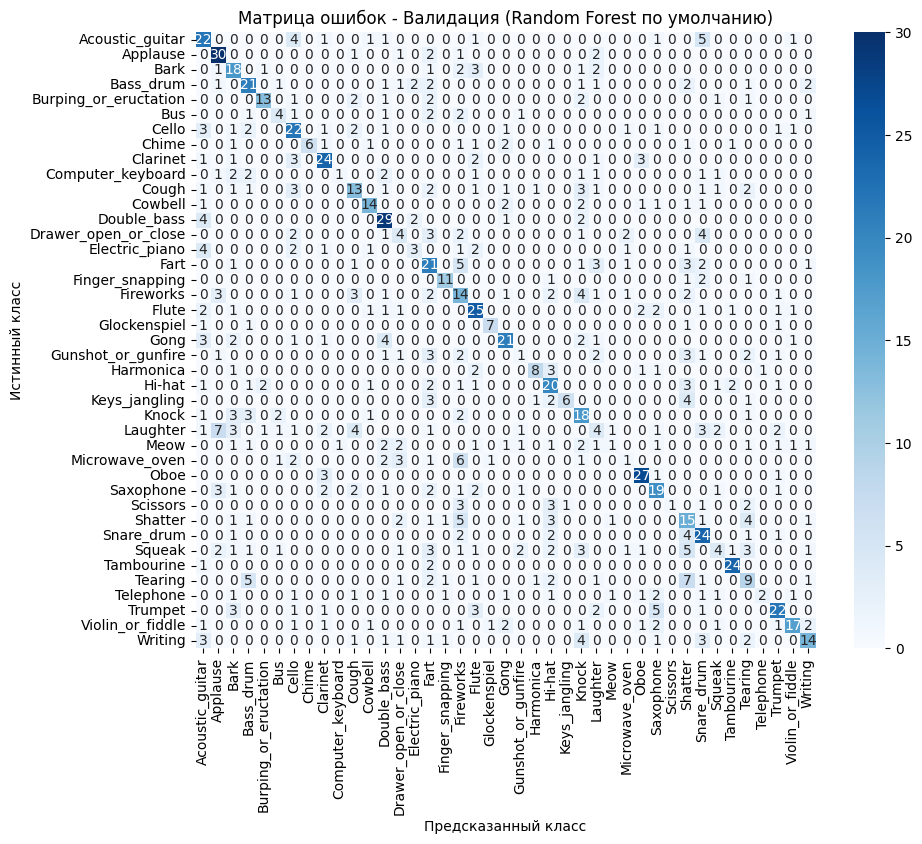


Подбор гиперпараметров для Random Forest с помощью GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Лучшие параметры, найденные GridSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Лучшая модель создана на основе GridSearchCV.

--- Результаты для Random Forest (с лучшими параметрами) ---
F1-score (weighted) на обучающей выборке: 1.0000
F1-score (weighted) на валидационной выборке: 0.4759

Отчет по классификации для валидационной выборки (лучшая модель):
                       precision    recall  f1-score   support

      Acoustic_guitar       0.44      0.59      0.51        37
             Applause       0.61      0.81      0.70        37
                 Bark       0.41      0.62      0.49        29
            Bass_drum       0.53      0.58      0.55        36
Burping_or_eructation       0.76      0.57      0.65        23
                  Bus       0.40      0.31      0.35        13
                Cello

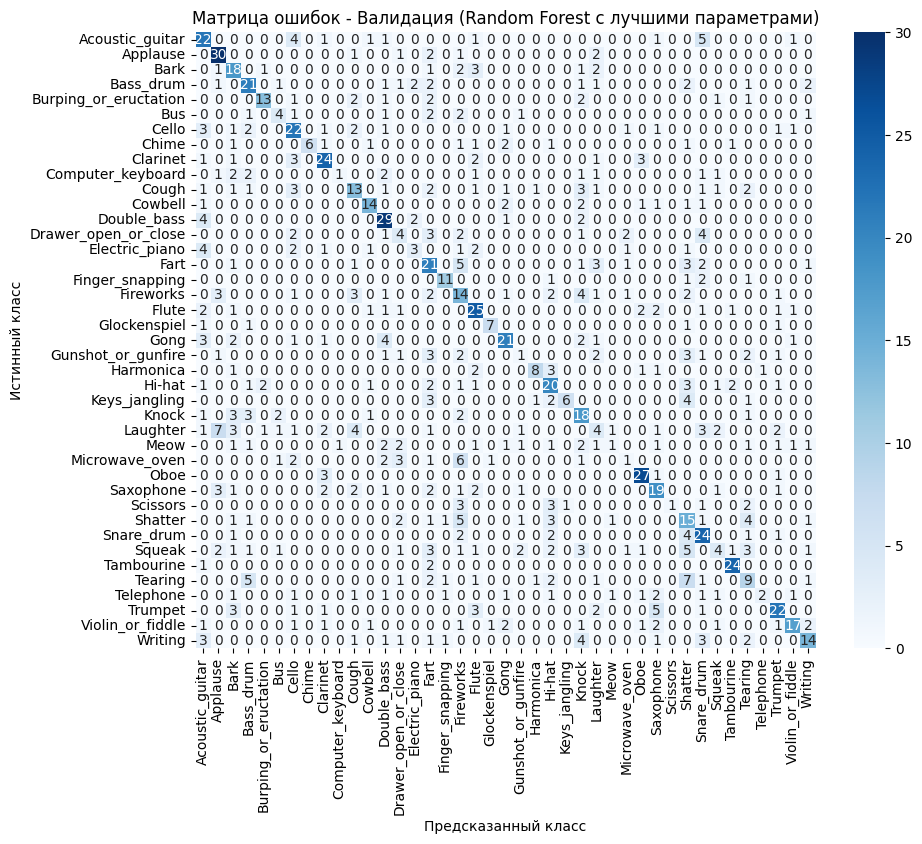


Лучшая модель Random Forest сохранена в /kaggle/working/trained_model.pkl

--- Выполнение лабораторной работы завершено ---


In [7]:
# ЧАСТЬ 2: ПОДГОТОВКА ДАННЫХ И ОБУЧЕНИЕ МОДЕЛИ

# Проверяем, что X и y существуют и не пусты
if 'X' in locals() and 'y' in locals() and X.size > 0 and y.size > 0:
    # Разделение данных на обучающую и валидационную выборки
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\nДанные разделены на обучающую и валидационную выборки:")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

    # --- Обучение модели Random Forest (с параметрами по умолчанию) ---
    print(f"\nОбучение модели Random Forest с параметрами по умолчанию...")
    rf_model_default = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model_default.fit(X_train, y_train)
    print("Модель обучена.")

    # Оценка модели на обучающей и валидационной выборках
    y_pred_train_default = rf_model_default.predict(X_train)
    y_pred_val_default = rf_model_default.predict(X_val)

    print(f"\n--- Результаты для Random Forest (по умолчанию) ---")
    print(f"F1-score (weighted) на обучающей выборке: {f1_score(y_train, y_pred_train_default, average='weighted'):.4f}")
    print(f"F1-score (weighted) на валидационной выборке: {f1_score(y_val, y_pred_val_default, average='weighted'):.4f}")
    
    print(f"\nОтчет по классификации для валидационной выборки (модель по умолчанию):")
    # Убедимся, что le.classes_ загружен или определен
    if 'le' in locals() and hasattr(le, 'classes_'):
        target_names_for_report = le.classes_
    else: # Резервный вариант, если le не был правильно инициализирован
        target_names_for_report = [str(i) for i in np.unique(np.concatenate((y_train, y_val)))]
        print("ПРЕДУПРЕЖДЕНИЕ: Используются числовые метки классов в отчете, т.к. LabelEncoder не был полностью инициализирован.")

    print(classification_report(y_val, y_pred_val_default, target_names=target_names_for_report))

    # Матрица ошибок для валидационной выборки
    cm_default = confusion_matrix(y_val, y_pred_val_default)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names_for_report, yticklabels=target_names_for_report)
    plt.title('Матрица ошибок - Валидация (Random Forest по умолчанию)')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()

    # Подбор гиперпараметров с помощью GridSearchCV
    print(f"\nПодбор гиперпараметров для Random Forest с помощью GridSearchCV...")
    param_grid = {
        'n_estimators': [50, 100],       
        'max_depth': [None, 10, 20],      
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    grid_search = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), 
                               param_grid, 
                               cv=3, # 3-х фолдовая кросс-валидация для скорости
                               scoring='f1_weighted', 
                               verbose=1) 
    grid_search.fit(X_train, y_train)

    print(f"\nЛучшие параметры, найденные GridSearchCV: {grid_search.best_params_}")
    best_rf_model = grid_search.best_estimator_
    print("Лучшая модель создана на основе GridSearchCV.")

    # Оценка лучшей модели
    y_pred_train_best = best_rf_model.predict(X_train)
    y_pred_val_best = best_rf_model.predict(X_val)

    print(f"\n--- Результаты для Random Forest (с лучшими параметрами) ---")
    print(f"F1-score (weighted) на обучающей выборке: {f1_score(y_train, y_pred_train_best, average='weighted'):.4f}")
    print(f"F1-score (weighted) на валидационной выборке: {f1_score(y_val, y_pred_val_best, average='weighted'):.4f}")

    print(f"\nОтчет по классификации для валидационной выборки (лучшая модель):")
    print(classification_report(y_val, y_pred_val_best, target_names=target_names_for_report))

    # Матрица ошибок для лучшей модели на валидационной выборке
    cm_best = confusion_matrix(y_val, y_pred_val_best)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names_for_report, yticklabels=target_names_for_report)
    plt.title('Матрица ошибок - Валидация (Random Forest с лучшими параметрами)')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()

    # Сохранение лучшей обученной модели
    with open(MODEL_PKL_PATH, 'wb') as f:
        pickle.dump(best_rf_model, f)
    print(f"\nЛучшая модель Random Forest сохранена в {MODEL_PKL_PATH}")

else:
    print("\nОШИБКА: Массивы признаков X или меток y не были корректно созданы или загружены. Обучение модели невозможно.")

print("\n--- Выполнение лабораторной работы завершено ---")